Import Dependencies

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
np.random.seed(123)

In [4]:
train_dir = '/kaggle/input/coviddataset-800-70-30-train-test/Covid-7-3/Train'
test_dir = '/kaggle/input/coviddataset-800-70-30-train-test/Covid-7-3/Test'

In [5]:
batch_size = 20
input_shape = (224, 224, 3)

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='binary')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='binary',
        shuffle=False)

Found 559 images belonging to 2 classes.
Found 241 images belonging to 2 classes.


In [9]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

for layer in vgg16.layers:
    layer.trainable = False

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                         

In [10]:
from keras.optimizers import Adam
opt = Adam(learning_rate=0.001, beta_1=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=3)
filepath_weights = "/kaggle/working/save_weights/best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath_weights, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, epochs=26, validation_data=test_generator, callbacks=[early_stop, checkpoint])

In [11]:
model.load_weights("/kaggle/input/best-weights-covid-binary/best_weights.hdf5")
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

13/13 [==============================] - 18s 481ms/step - loss: 0.2334 - accuracy: 0.9046
Test accuracy: 0.9045643210411072


In [12]:
y_true_classes = test_generator.classes
y_pred = model.predict(test_generator)


13/13 [==============================] - 4s 307ms/step


In [ ]:
y_pred.flatten()

Somehow .flatten effects np.mean

In [ ]:
y_pred_classes = (y_pred > 0.5).astype(int)
np.mean(y_true_classes == y_pred_classes)

In [14]:
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
np.mean(y_true_classes == y_pred_classes)

0.9045643153526971

In [ ]:
y_pred_classes.flatten()

In [ ]:
y_true_classes

In [15]:
print(classification_report(y_true_classes, y_pred_classes))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90       121
           1       0.90      0.91      0.90       120

    accuracy                           0.90       241
   macro avg       0.90      0.90      0.90       241
weighted avg       0.90      0.90      0.90       241



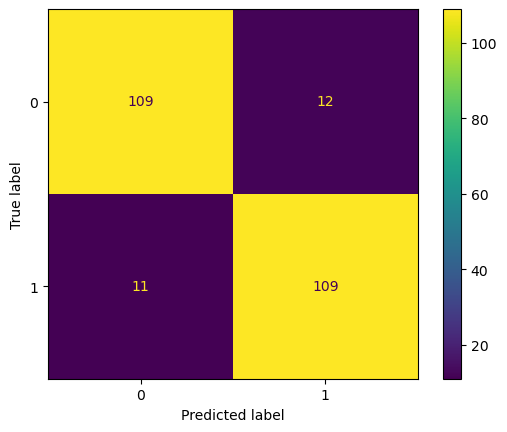

In [16]:
print(ConfusionMatrixDisplay.from_predictions(y_true_classes, y_pred_classes))

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

test_images, test_labels = next(test_generator)
test_pred = model.predict(test_images)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10,10))
for i, ax in enumerate(axes.flat):
    # Plot image
    ax.imshow(test_images[i])

    # Set the title
    if test_pred[i][0] > 0.5:
        title = f'COVID ({test_pred[i][0]:.2f})'
    else:
        title = f'Non-COVID ({test_pred[i][1]:.2f})'
    ax.set_title(title)

    # Remove ticks from the plot
    ax.set_xticks([])
    ax.set_yticks([])